In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import norm
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
import seaborn as sns

In [2]:
def tempered_sampling(distribution, T, N, alpha=1.0, batch_size=None):
    if batch_size is None:
        sample_shape = (N,)
    else:
        sample_shape = (batch_size, N)
    points = distribution.sample(sample_shape)
    pdfs = torch.exp(distribution.log_prob(points))
    weights = alpha*(1/T - 1) * pdfs
    index = Categorical(logits=weights).sample()
    if batch_size is not None:
        return points[torch.arange(len(index)), index]
    else:
        return points[index]

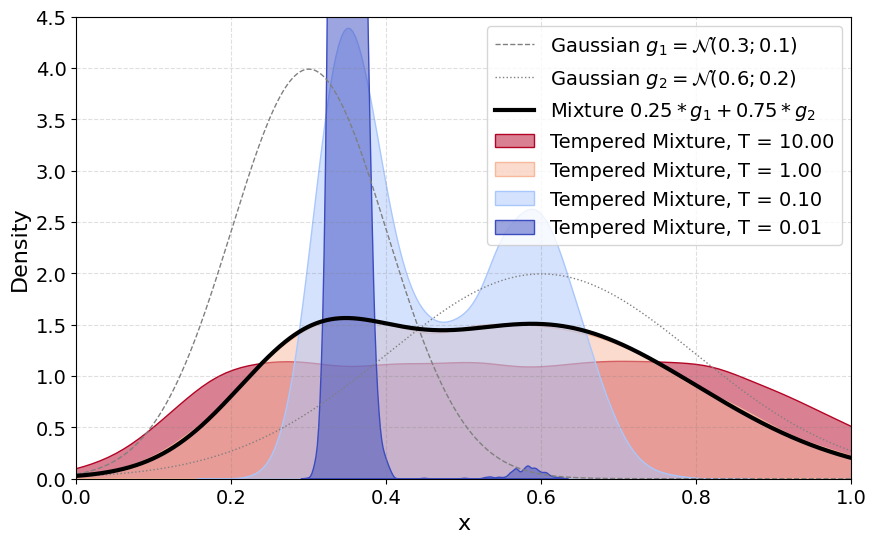

In [72]:
# Parameters for the Gaussians
mu1, sigma1 = 0.3, 0.1    # Mean and standard deviation of the first Gaussian
mu2, sigma2 = 0.6, 0.2    # Mean and standard deviation of the second Gaussian
weight1 = 0.25             # Weight of the first Gaussian
weight2 = 0.75             # Weight of the second Gaussian

# Generate points on the x axis
x = np.linspace(0, 1, 1000)

# The two Gaussian functions
gaussian1 = norm.pdf(x, mu1, sigma1)
gaussian2 = norm.pdf(x, mu2, sigma2)

# The mixture of the two Gaussians
gmm_dist = MixtureSameFamily(
    mixture_distribution=Categorical(probs=torch.tensor([weight1, weight2])),
    component_distribution=Normal(loc=torch.tensor([mu1, mu2]), scale=torch.tensor([sigma1, sigma2])),
)

# temperatures = [10, 1.0, 0.1, 0.01]
temperatures = [1e1, 1e0, 1e-1, 1e-2]
# Normalize the temperature values for colormap mapping
normalize = mcolors.Normalize(vmin=np.log(min(temperatures)), vmax=np.log(max(temperatures)))
cmap = plt.get_cmap('coolwarm')

plt.figure(figsize=(10, 6))
plt.plot(x, gaussian1, label=f'Gaussian $g_1 = $' + '$\mathcal{N}$' + f'$({mu1};{sigma1})$', color='gray', linestyle='--', linewidth=1)
# plt.fill_between(x, gaussian1, color='blue', alpha=weight1/2)
plt.plot(x, gaussian2, label=f'Gaussian $g_2 = $' + '$\mathcal{N}$' + f'$({mu2};{sigma2})$', color='gray', linestyle=':', linewidth=1)
# plt.fill_between(x, gaussian2, color='blue', alpha=weight2/2)
plt.plot(x, weight1*gaussian1 + weight2*gaussian2, label=f'Mixture ${weight1}*g_1 + {weight2}*g_2$', color='black', linewidth=3)
# plt.fill_between(x, weight1*gaussian1 + weight2*gaussian2, color='black', alpha=0.2)
for i, T in enumerate(temperatures):
    samples = tempered_sampling(gmm_dist, T=T, N=10000, alpha=1.0, batch_size=30000)
    sns.kdeplot(samples, bw_adjust=1.0, fill=True, label=f'Tempered Mixture, T = {T:.2f}', color=cmap(normalize(np.log(T))), linewidth=1, alpha=0.5)

plt.legend(fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 4.5)
plt.xlabel('x', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.savefig('tempered_sampling.pdf')
plt.show()